In [9]:
from google.colab import drive
drive.mount('/content/drive')
!pip install keras_preprocessing
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, concatenate, MaxPool2D, AvgPool2D, Dropout


from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
#Data Science Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [4]:
dataset = "/content/drive/MyDrive/fire_dataset-2"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/drive/MyDrive/fire_dataset-2'.
There are 0 directories and 755 images in '/content/drive/MyDrive/fire_dataset-2/fire_images'.
There are 0 directories and 244 images in '/content/drive/MyDrive/fire_dataset-2/non_fire_images'.


In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
len(list(image_dir.glob(r'**/*.png')))


999

In [7]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
1,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
2,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
3,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
4,/content/drive/MyDrive/fire_dataset-2/fire_ima...,fire_images
...,...,...
994,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images
995,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images
996,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images
997,/content/drive/MyDrive/fire_dataset-2/non_fire...,non_fire_images


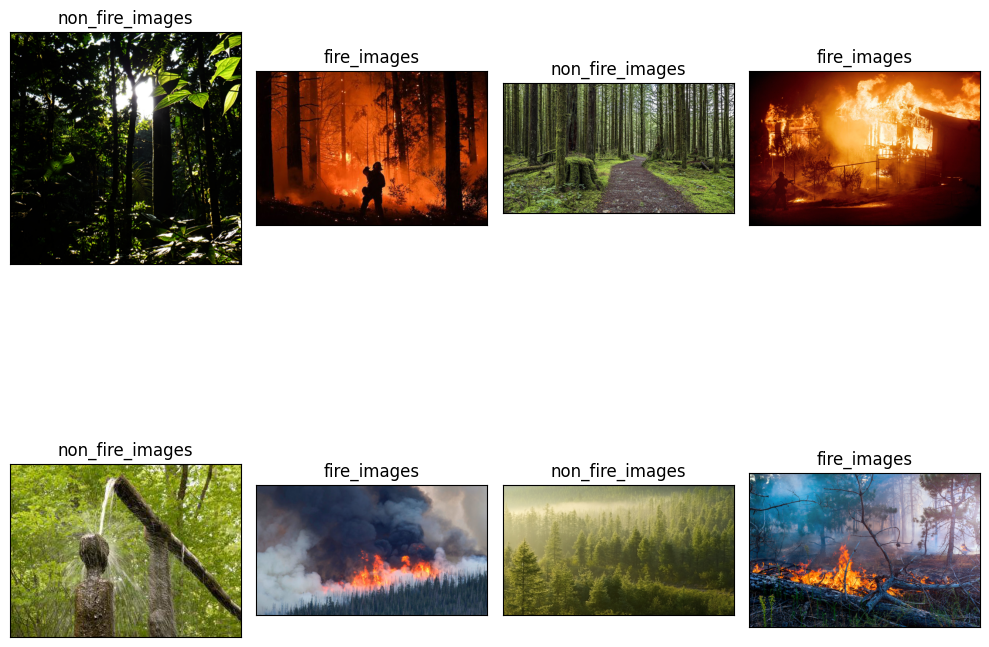

In [11]:
import matplotlib.image as mpimg
# Display 8 picture with their labels
random_index = np.random.randint(0, len(image_df), 8)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [12]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [20]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [21]:
# Split the data train,test and validation
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [22]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
input_shape=(224,224,3)
def FireNet(input_shape):
  model = keras.models.Sequential([ layers.Conv2D(96, (11,11), strides=(4,4), activation="relu", input_shape = input_shape),
                                      layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

                                      layers.Conv2D(256, (5,5), activation="relu"),
                                      layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

                                      layers.Conv2D(384, (5,5), activation="relu"),
                                      layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

                                      layers.Flatten(),
                                      layers.Dropout(0.3),

                                      layers.Dense(2048, activation="relu"),
                                      layers.Dropout(0.3),

                                      layers.Dense(1024, activation="relu"),
                                      layers.Dropout(0.3),

                                      layers.Dense(2, activation="softmax")
                                     ])

  model.compile(loss = "categorical_crossentropy",
                  optimizer = Adam(0.0001),
                  metrics = ["accuracy"])

  return model

In [28]:
model = FireNet(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         2457984   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 384)       

In [31]:
history = model.fit( train_images,
                     steps_per_epoch = len(train_images),
                     epochs = 20,
                     validation_data = val_images,
                    validation_steps = len(val_images) )

Epoch 1/20
20/20 [==============================] - 80s 4s/step - loss: 0.1459 - accuracy: 0.9516
Epoch 2/20
20/20 [==============================] - 77s 4s/step - loss: 0.1128 - accuracy: 0.9547
Epoch 3/20
20/20 [==============================] - 77s 4s/step - loss: 0.1052 - accuracy: 0.9563
Epoch 4/20
20/20 [==============================] - 77s 4s/step - loss: 0.0902 - accuracy: 0.9656
Epoch 5/20
20/20 [==============================] - 77s 4s/step - loss: 0.0779 - accuracy: 0.9703
Epoch 6/20
20/20 [==============================] - 78s 4s/step - loss: 0.0636 - accuracy: 0.9797
Epoch 7/20
20/20 [==============================] - 77s 4s/step - loss: 0.0645 - accuracy: 0.9797
Epoch 8/20
20/20 [==============================] - 77s 4s/step - loss: 0.0468 - accuracy: 0.9859
Epoch 9/20
20/20 [==============================] - 77s 4s/step - loss: 0.0790 - accuracy: 0.9672
Epoch 10/20
20/20 [==============================] - 78s 4s/step - loss: 0.0667 - accuracy: 0.9766
Epoch 11/20
20/20 [

In [32]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.19792
Test Accuracy: 96.00%


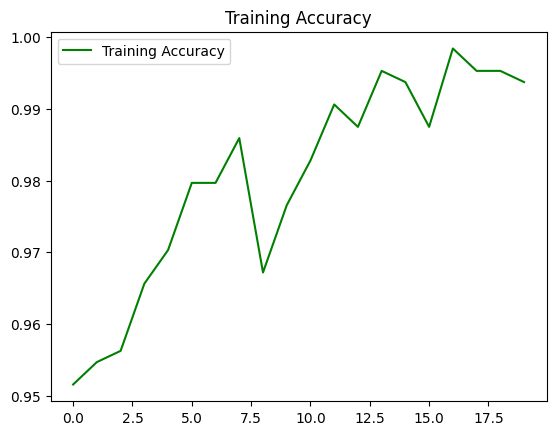

<Figure size 640x480 with 0 Axes>

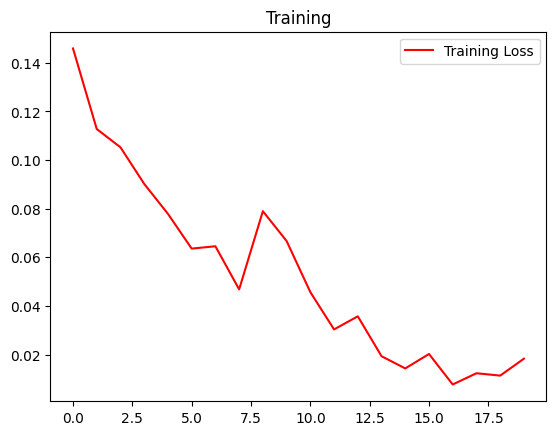

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
loss = history.history["loss"]

epochs = range(0,20)


plt.plot(epochs, acc, "g", label="Training Accuracy")
plt.title("Training Accuracy")

plt.legend(loc=0)
plt.figure()
plt.show()


plt.plot(epochs, loss, "r",label="Training Loss")
plt.title("Training")

plt.legend(loc=0)
plt.figure()
plt.show()



In [42]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 14s 2s/step
The first 5 predictions: ['fire_images', 'non_fire_images', 'fire_images', 'fire_images', 'fire_images']


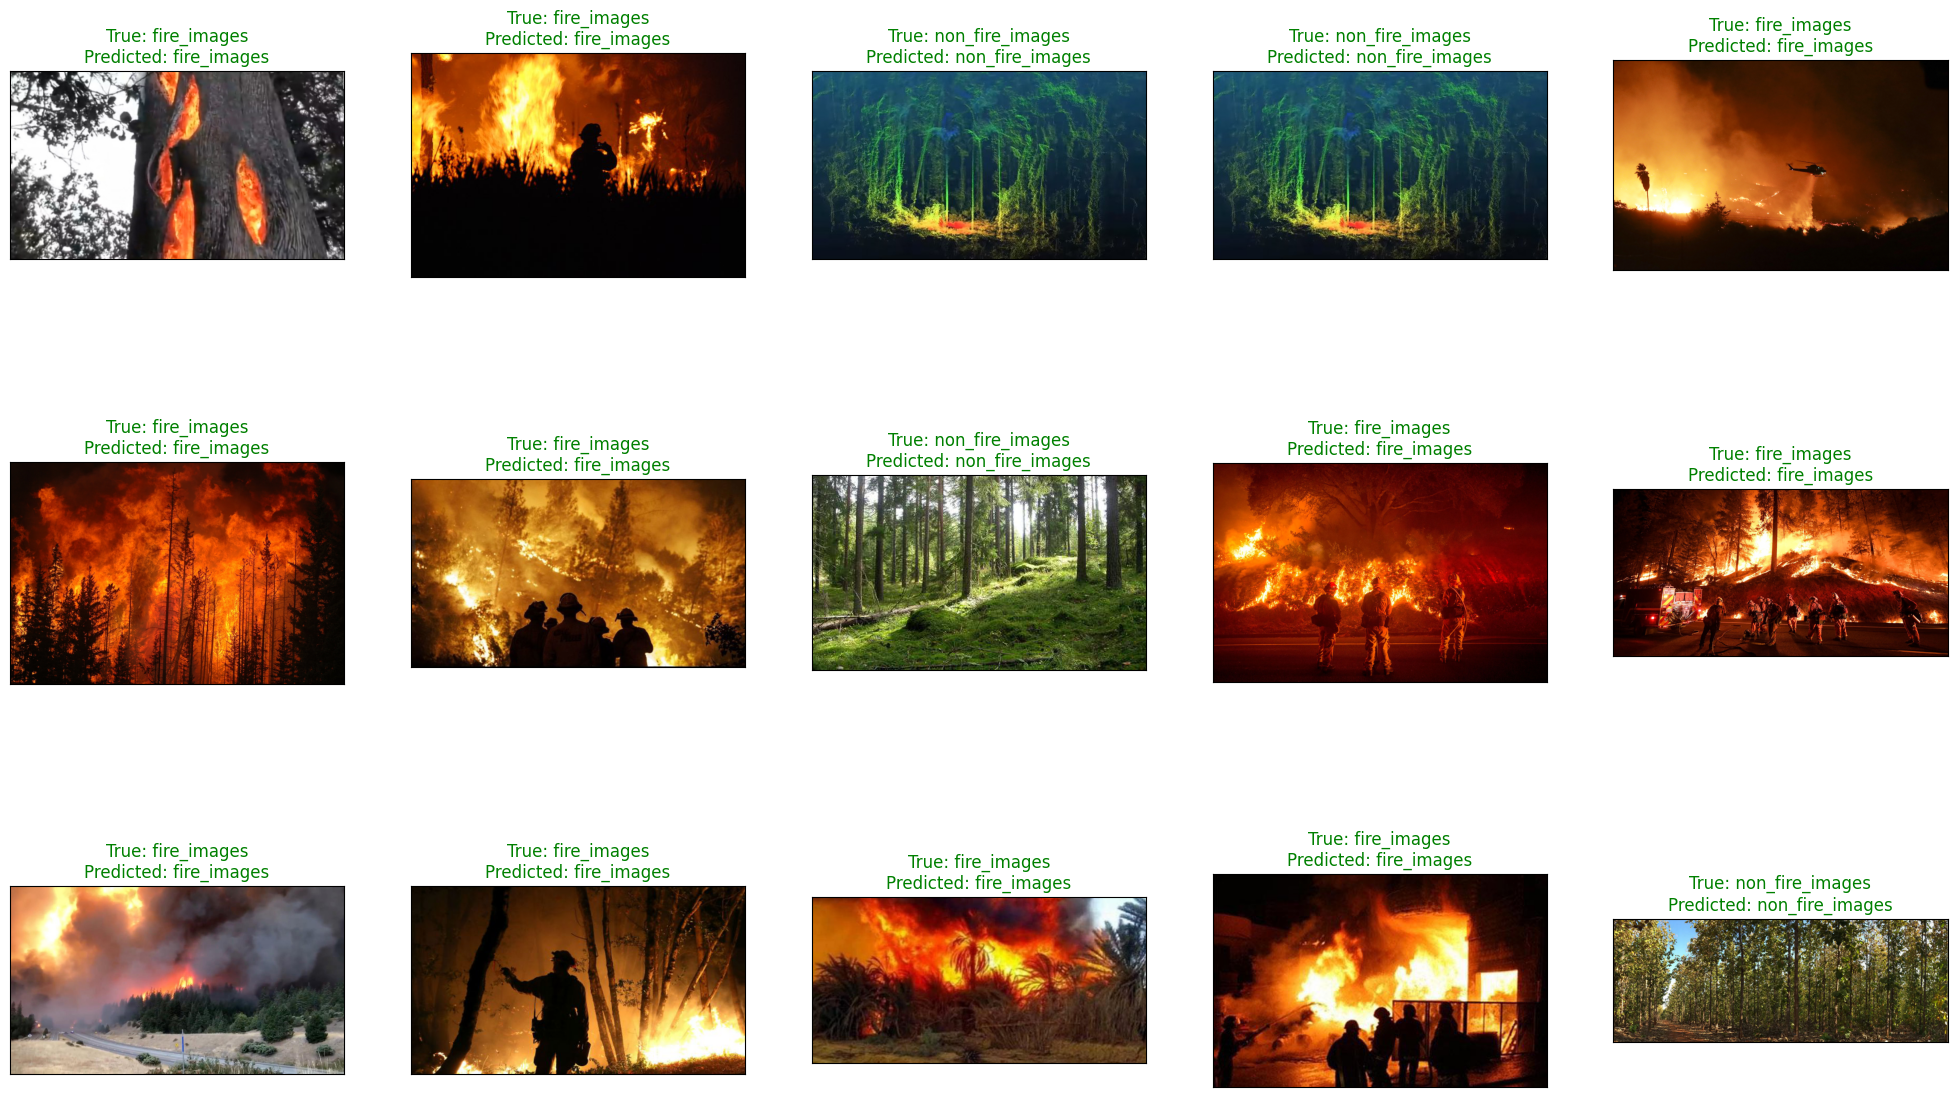

<Figure size 640x480 with 0 Axes>

In [43]:
  # Display 15 random pictures with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [44]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.96      0.99      0.97       148
non_fire_images       0.96      0.88      0.92        52

       accuracy                           0.96       200
      macro avg       0.96      0.94      0.95       200
   weighted avg       0.96      0.96      0.96       200



In [45]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.960526,0.986486,0.973333,148.00
non_fire_images,0.958333,0.884615,0.920000,52.00
accuracy,0.960000,0.960000,0.960000,0.96
macro avg,0.959430,0.935551,0.946667,200.00
weighted avg,0.959956,0.960000,0.959467,200.00


In [46]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):

  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


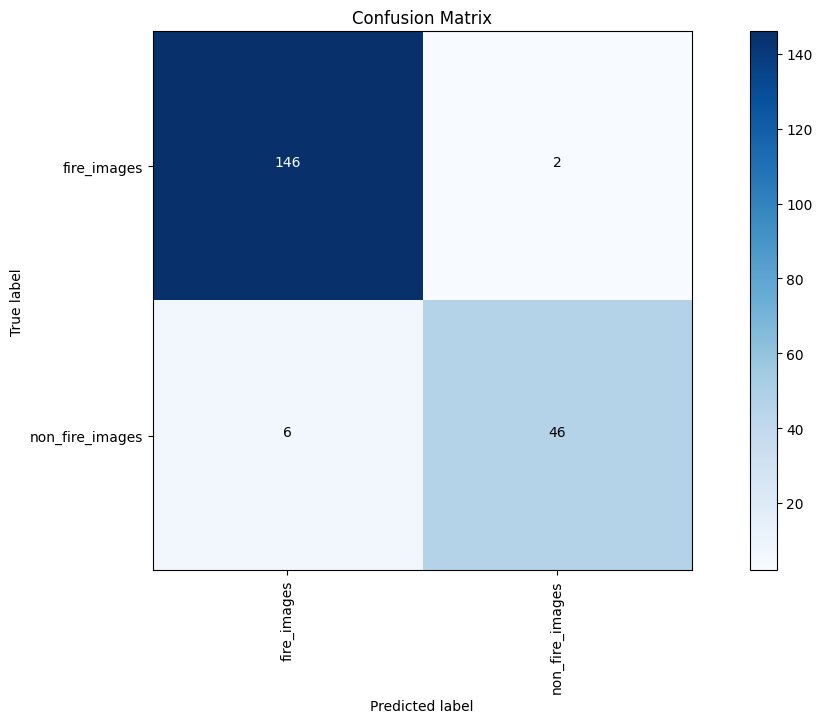

In [47]:
make_confusion_matrix(y_test, pred, list(labels.values()))